You need all these liberaries in your environment

conda install pandas numpy matplotlib seaborn scikit-learn
pip install tslearn fastdtw


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import psutil
import time
import hdbscan


# Ensure plots are displayed inline
%matplotlib inline


print("All libraries imported successfully!")

All libraries imported successfully!


In [7]:
# Load the main dataset
data = pd.read_csv('data2.csv')
data = pd.get_dummies(data, columns=[])

#print(data.head())

# Load your selected columns from the specified path
selected_columns_path = 'AirEau_features_lag15.csv'
selected_columns_df = pd.read_csv(selected_columns_path)

# Select only the feature column
selected_columns = selected_columns_df['Feature'].tolist()

# Select the data for analysis
data_selected = data[selected_columns]

# Check if the first column is date and time, and drop it if necessary
if 'Date' in data_selected.columns or 'Time' in data_selected.columns:
    data_selected = data_selected.drop(columns=['Date', 'Time'], errors='ignore')



In [8]:
# Preprocess the data
X = data_selected.values  # Adjust based on your data structure
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:

# Determine the maximum allowable number of PCA components
max_components = min(X_scaled.shape)
max_components

25

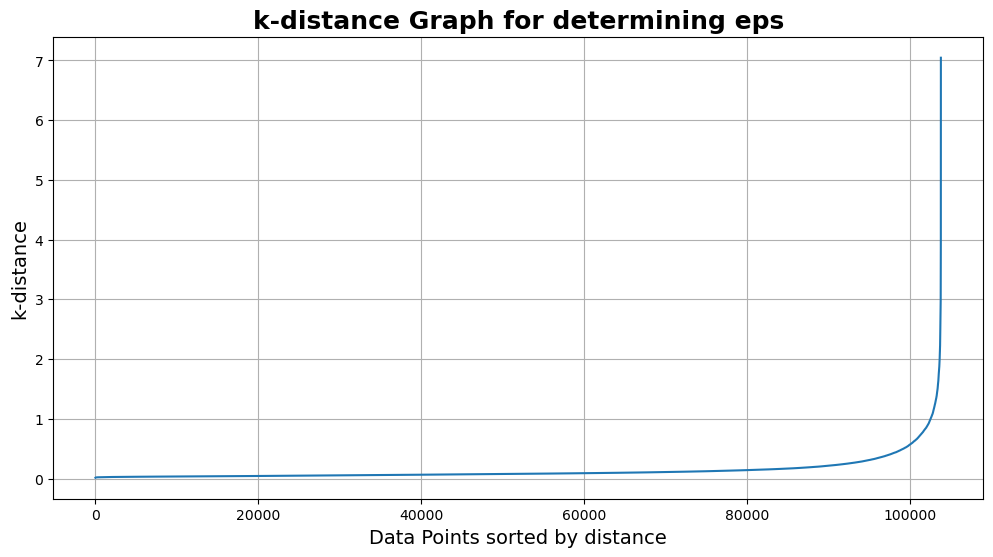

In [10]:
# Perform PCA
n_components = min(40, max_components)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Determine `eps` using the k-distance graph
def plot_k_distance_graph(X, n_neighbors=5):
    nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors = nearest_neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    distances = np.sort(distances[:, n_neighbors - 1])
    
    plt.figure(figsize=(12, 6))
    plt.plot(distances)
    plt.title('k-distance Graph for determining eps', fontsize=18, weight='bold')
    plt.xlabel('Data Points sorted by distance', fontsize=14)
    plt.ylabel('k-distance', fontsize=14)
    plt.grid(True)
    plt.show()

plot_k_distance_graph(X_pca)

eps (Epsilon)
Definition: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
Role: It defines the radius of a neighborhood around a point. Points within this distance from a given point are considered its neighbors.
Impact: A smaller eps value will result in smaller clusters, potentially considering more points as noise. A larger eps value will result in larger clusters but may merge distinct clusters together.

min_samples
Definition: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
Role: It defines the minimum number of points required to form a dense region (a core point).
Impact: A higher min_samples value will result in fewer clusters with more points labeled as noise. A lower min_samples value will result in more clusters, possibly including clusters of noise points.

In [12]:
# Choose eps and min_samples based on k-distance graph and domain knowledge
eps_value = 1.0  # Replace with the value obtained from k-distance graph
min_samples_value = 5  # Choose based on data and domain knowledge

In [13]:
# Perform DBSCAN clustering
dbscan = DBSCAN(metric="euclidean", eps=eps_value, min_samples=min_samples_value)
y_dbscan = dbscan.fit_predict(X_pca)

# Check if DBSCAN found more than one cluster
if len(set(y_dbscan)) > 1:
    silhouette_avg_dbscan = silhouette_score(X_pca, y_dbscan)
    print(f'DBSCAN Silhouette Score: {silhouette_avg_dbscan:.2f}')
else:
    print("DBSCAN did not find more than one cluster. Try adjusting the parameters.")

DBSCAN Silhouette Score: 0.01


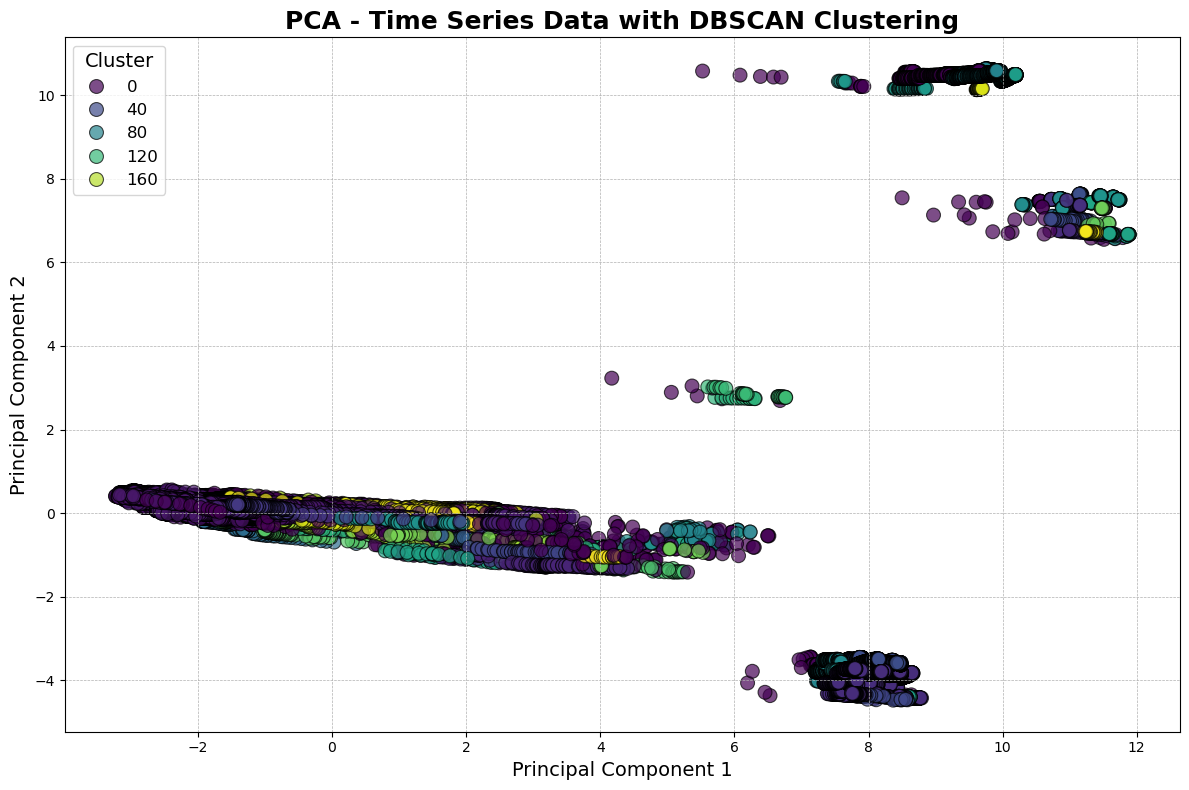

In [14]:
# Visualize clustering results in 2D (DBSCAN)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_dbscan, palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.title('PCA - Time Series Data with DBSCAN Clustering', fontsize=18, weight='bold')
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

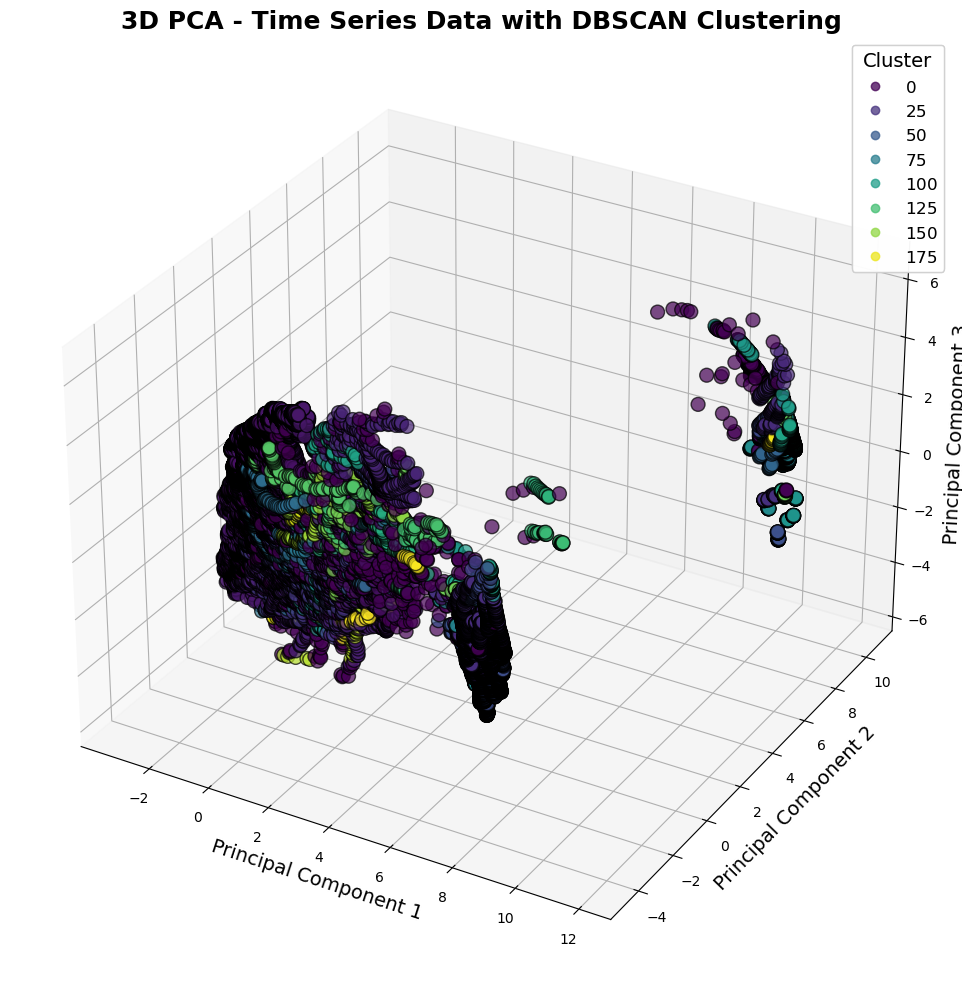

In [16]:
# Visualize clustering results in 3D (DBSCAN)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_dbscan, cmap='viridis', s=100, alpha=0.7, edgecolor='k')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", fontsize=12, title_fontsize=14)
ax.add_artist(legend1)
ax.set_title('3D PCA - Time Series Data with DBSCAN Clustering', fontsize=18, weight='bold')
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [21]:
# Perform HDBSCAN clustering
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10)
y_hdbscan = hdbscan_clusterer.fit_predict(X_pca)

In [23]:
# Check if HDBSCAN found more than one cluster
if len(set(y_hdbscan)) > 1:
    silhouette_avg_hdbscan = silhouette_score(X_pca, y_hdbscan)
    print(f'HDBSCAN Silhouette Score: {silhouette_avg_hdbscan:.2f}')
else:
    print("HDBSCAN did not find more than one cluster. Try adjusting the parameters.")

HDBSCAN Silhouette Score: 0.03


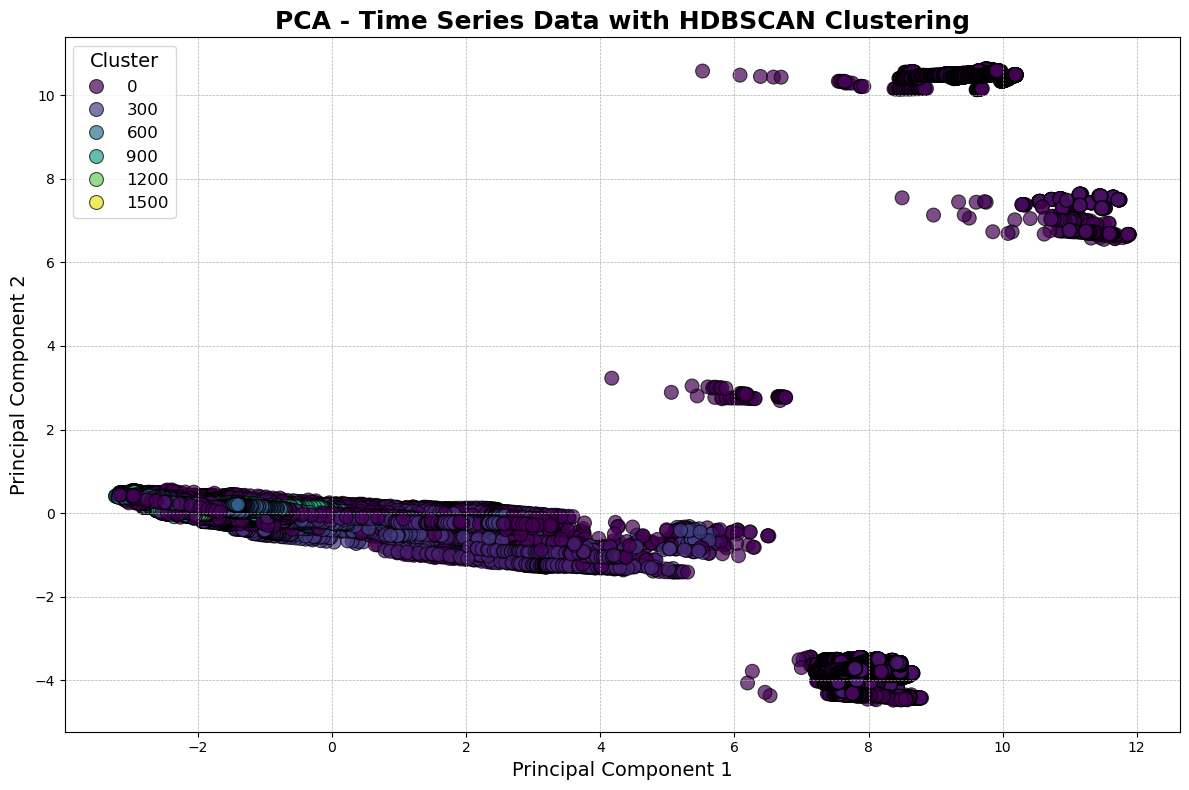

In [24]:


# Visualize clustering results in 2D (HDBSCAN)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_hdbscan, palette='viridis', s=100, alpha=0.7, edgecolor='k')
plt.title('PCA - Time Series Data with HDBSCAN Clustering', fontsize=18, weight='bold')
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

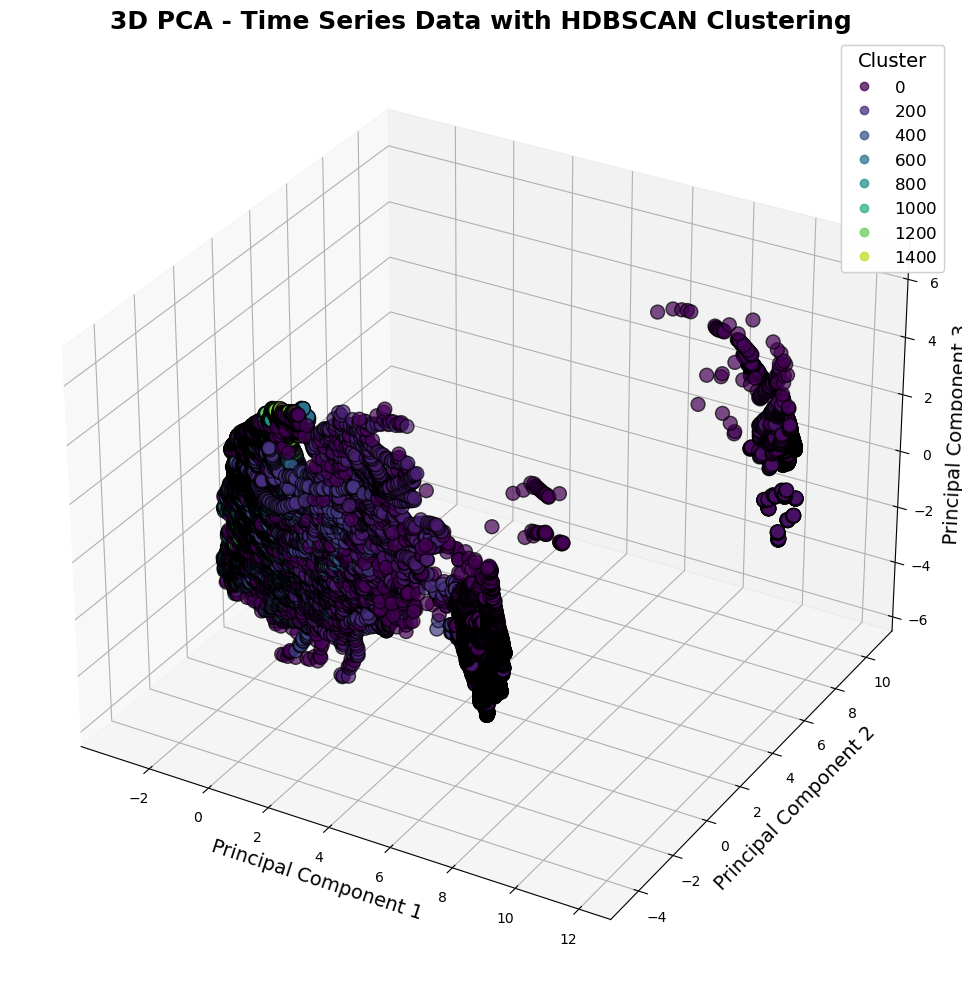

In [25]:


# Visualize clustering results in 3D (HDBSCAN)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_hdbscan, cmap='viridis', s=100, alpha=0.7, edgecolor='k')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster", fontsize=12, title_fontsize=14)
ax.add_artist(legend1)
ax.set_title('3D PCA - Time Series Data with HDBSCAN Clustering', fontsize=18, weight='bold')
ax.set_xlabel('Principal Component 1', fontsize=14)
ax.set_ylabel('Principal Component 2', fontsize=14)
ax.set_zlabel('Principal Component 3', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()